# Step 1 - Data Gathering

In [1]:
import numpy as np
import data_processor
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from collections import defaultdict

%matplotlib inline

seed = 1234

### Getting the Data

In [2]:
get_data_from_file = False  # faster when this is False
DATA_IMG_SIZE = (175, 175)

# get data from file
if (get_data_from_file):
    DATA_FILE = "data_images_100_100.txt"
    data = np.genfromtxt(DATA_FILE)
    X = data[:, :-1]
    y = data[:, -1]

# generate data here
if not get_data_from_file:
    X, y = data_processor.convert_images(DATA_IMG_SIZE, True)
    X = np.array(X)
    y = np.char.lower(np.array(y))


--- Done reading legend.csv ---
--- Done turning images into vectors ---


### Preprocessing the Data

In [3]:
counts = defaultdict(int)
for i in y:
    counts[i] += 1
print('before oversampling:')
print(counts)

# compute indices of classes
contempt_i = np.where(y == 'contempt')[0]
fear_i = np.where(y == 'fear')[0]
disgust_i = np.where(y == 'disgust')[0]
anger_i = np.where(y == 'anger')[0]
sadness_i = np.where(y == 'sadness')[0]
surprise_i = np.where(y == 'surprise')[0]

# calculate how many times to duplicate data
contempt_times = int(counts['neutral'] / counts['contempt']) - 1
fear_times = int(counts['neutral'] / counts['fear']) - 1
disgust_times = int(counts['neutral'] / counts['disgust']) - 1
anger_times = int(counts['neutral'] / counts['anger']) - 1
sadness_times = int(counts['neutral'] / counts['sadness']) - 1
surprise_times = int(counts['neutral'] / counts['surprise']) - 1

contempt_X = np.repeat(X[contempt_i], contempt_times, axis=0)
fear_X = np.repeat(X[fear_i], fear_times, axis=0)
disgust_X = np.repeat(X[disgust_i], disgust_times, axis=0)
anger_X = np.repeat(X[anger_i], anger_times, axis=0)
sadness_X = np.repeat(X[sadness_i], sadness_times, axis=0)
surprise_X = np.repeat(X[surprise_i], surprise_times, axis=0)

X_balanced = np.concatenate((X, contempt_X, fear_X, disgust_X, anger_X, sadness_X, surprise_X), axis=0)
y_balanced = np.concatenate((y,
                                np.repeat(['contempt'], contempt_times * counts['contempt']),
                                np.repeat(['fear'], fear_times * counts['fear']),
                                np.repeat(['disgust'], disgust_times * counts['disgust']),
                                np.repeat(['anger'], anger_times * counts['anger']),
                                np.repeat(['sadness'], sadness_times * counts['sadness']),
                                np.repeat(['surprise'], surprise_times * counts['surprise'])), axis=0)

counts_after = defaultdict(int)
for i in y_balanced:
    counts_after[i] += 1
print('\nafter:')
print(counts_after)


before oversampling:
defaultdict(<class 'int'>, {'neutral': 6717, 'happiness': 5309, 'surprise': 355, 'sadness': 124, 'anger': 227, 'contempt': 9, 'disgust': 12, 'fear': 12})

after:
defaultdict(<class 'int'>, {'neutral': 6717, 'happiness': 5309, 'surprise': 6390, 'sadness': 6696, 'anger': 6583, 'contempt': 6714, 'disgust': 6708, 'fear': 6708})


In [4]:
# shuffle oversampled data
np.random.seed(seed)
shuffled_indices = np.arange(y_balanced.shape[0])
np.random.shuffle(shuffled_indices)

X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

In [5]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# encode y (str -> int)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_balanced)
label_mapping = pd.DataFrame({'class_label': label_encoder.classes_, 'numeric_label': np.arange(len(label_encoder.classes_))})
label_mapping.to_csv('label_mapping.csv', index=False)
num_classes = len(label_encoder.classes_)

# channels = 1 --> grayscale
original_height, original_width, channels = *DATA_IMG_SIZE, 1

# scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
# reshape X
X_reshaped = X_scaled.reshape(-1, original_height, original_width, channels)

# split the training and testing data
X_tr, X_te, y_tr, y_te = train_test_split(X_reshaped, y_encoded, test_size=0.1, random_state=seed, shuffle=True)


# Step 2 - Building the Convolutional Neural Network

### Create and Test an Initial CNN

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd

# first 10000 of train for training, rest of train for validation
X_tr_train = X_tr[:40000, :]    # shape = (10000, 10000)
y_tr_train = y_tr[:40000]       # shape = (2321, 10000)
X_tr_val = X_tr[40000:, :]      # shape = (10000, )
y_tr_val = y_tr[40000:]         # sahpe = (2321, )

# create the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(original_height, original_width, channels)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# build the CNN model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train the CNN model
history = model.fit(X_tr_train, y_tr_train, epochs=3, validation_data=(X_tr_val, y_tr_val))

# evalulate the CNN model
result = model.evaluate(X_te, y_te)
result_dict = dict(zip(model.metrics_names, result))
print(f"Model Result\n-----\n{result_dict}")





Epoch 1/3


1250/1250 [==============================] - 345s 274ms/step - loss: 0.2925 - accuracy: 0.9004 - val_loss: 0.0990 - val_accuracy: 0.9612
Epoch 2/3
1250/1250 [==============================] - 326s 261ms/step - loss: 0.0611 - accuracy: 0.9758 - val_loss: 0.0804 - val_accuracy: 0.9649
Epoch 3/3
162/162 [==============================] - 10s 61ms/step - loss: 0.1184 - accuracy: 0.9664
Model Result
-----
{'loss': 0.11839067190885544, 'accuracy': 0.9664286971092224}


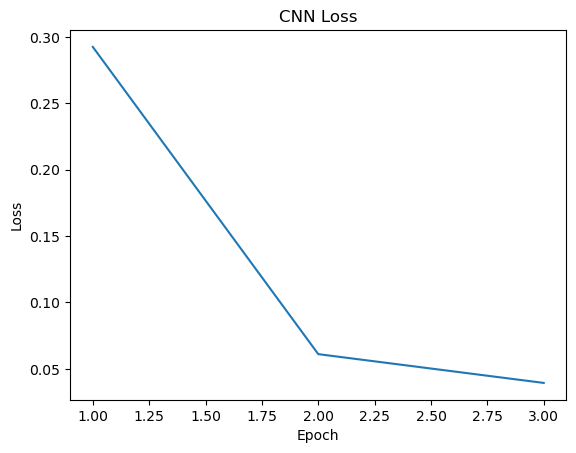

{'loss': [0.29246631264686584, 0.06105291098356247, 0.03937366604804993], 'accuracy': [0.9004250168800354, 0.9757500290870667, 0.9852250218391418], 'val_loss': [0.09897999465465546, 0.08044109493494034, 0.11003586649894714], 'val_accuracy': [0.9611562490463257, 0.9649202227592468, 0.9655224084854126]}


In [11]:
import matplotlib.pyplot as plt


plt.plot(range(1, 4), history.history["loss"])
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print(history.history)

In [16]:
result = model.evaluate(X_tr_val, y_tr_val)
result_dict = dict(zip(model.metrics_names, result))
print(f"Model Result\n-----\n{result_dict}")

208/208 [==============================] - 15s 71ms/step - loss: 0.1100 - accuracy: 0.9655
Model Result
-----
{'loss': 0.11003586649894714, 'accuracy': 0.9655224084854126}


MemoryError: Unable to allocate 4.56 GiB for an array with shape (40000, 175, 175, 1) and data type float32